# Evaluation of 1 Model With Physgen

In [ ]:
model_1 = "transunet_1_0"  # hexa_wave_net_7_reflection_only, pix2pix_1_0_residual_few_bui_weight_loss_wgangp, pix2pix_1_0_residual_few_bui_weight_loss_wgangp_l1
model_1_type = "transunet"  # hexa_wave_net, pix2pix, pix2pix_cfo, stacked_resunet, pinn, transunet, transconvunext
# for Hexa-Wave Net
model_variation = 7  # 1, 2, 3, 7, 8

data_1 = "../../data/nms1000_test_residual_reflection"
data_1_type = "physgen"  # physgen, noise
physgen_variation = "sound_reflection"    # sound_baseline, sound_reflection, sound_diffraction, sound_combined
different_naming_1 = False

batch_size = 1
data_to_process_size = "inf"
image_size = 256

### Env Setup

In [25]:
# !conda create -n eval python=3.8 -y
# !conda activate eval

Activate now eval env and run:

In [26]:
# !pip install pandas
# !pip install ipython
# !pip install ipykernel
# !pip install opencv-python
# !pip install shapely
# !pip install pytorch-msssim
# !pip install scikit-image
# !pip install -r requirements.txt
# !pip install kornia

> Set 'eval' as your python env

### Imports

In [27]:
import os
import re
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cv2

In [28]:
!python --version

Python 3.8.20


### Helper

In [29]:
def imshow(img, title=None, image_width=10, axis=False,
           color_space="RGB", cmap=None, cols=1, save_to=None,
           hspace=0.2, wspace=0.2,
           use_original_sytle=False, invert=False):
    """
    Visualizes one or multiple images.

    Image will be reshaped: [batch_size/images, width, height, channels]

    ---
    Parameters:
    - img : np.ndarray
        Images/Images with [width, height, channels] or for multiple: [batch_size/images, width, height, channels].
    - title : str, optional (default=None)
        Title of the whole plot.
    - image_width : int, optional (default=5)
        Width of one image in the plot.
    - axis : bool, optional (default=False)
        Whether to print the axis of the images or not.
    - color_space : str, optional (default="RGB")
        The colorspace of the image: RGB, BGR, gray, HSV.
    - cmap : str, optional (default=None)
        Which cmap to use. Check all cmaps here out: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    - cols : int, optional (default=1)
        Amount of columns in the plot.
    - save_to : str, optional (default=None)
        Path where to save the result image.
    - hspace : float, optional (default=0.01)
        Horizontal space between the images.
    - wspace : float, optional (default=0.01)
        Vertical space between the images.
    - use_original_sytle : bool, optonial (default=False)
        Whether the plot should use the current active matplotlib style or choosing a own one. 
    - invert : bool, optional (default=False)
        Whether to invert the images or not.
    """
    original_style = plt.rcParams.copy()

    img_shape = img.shape
    print(f"Got images with shape: {img_shape}")

    # tranform the image to the right form
    if len(img_shape) == 2:
        img = np.reshape(img, shape=(1, img.shape[0], img.shape[1], 1))
    elif len(img_shape) == 3:
        # check if multiple gray images or multiple images with channel
        # if img.shape[2] < img.shape[0] and img.shape[1] == img.shape[2]:
        img = np.reshape(img, shape=(1, img.shape[0], img.shape[1], img.shape[2]))
        # else:
        #     # there could be cases where this is wrong
        #     img = np.reshape(img, shape=(img.shape[0], img.shape[1], img.shape[2], 1))
    elif len(img_shape) != 4:
        raise ValueError(f"Image(s) have wrong shape! Founded shape: {img.shape}.")

    print(f"Transformed shape to: {img_shape}")

    # invert images
    if invert:
        print("Invert images...")
        max_value = 2**(img.dtype.itemsize * 8) -1
        scaling_func = lambda x: max_value - x
        img = np.apply_along_axis(scaling_func, axis=0, arr=img)

    # Set visualization settings
    # aspect_ratio_width = img.shape[1] / img.shape[2]
    aspect_ratio = img.shape[2] / img.shape[1]

    n_images = img.shape[0]
    rows = n_images//cols + int(n_images % cols > 0)

    width = int(image_width * cols)
    height = int(image_width * rows * aspect_ratio)

    # set plt style
    if not use_original_sytle:
        plt_style = 'seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else np.random.choice(plt.style.available)
        plt.style.use(plt_style)
        print(f"Using '{plt_style}' plotting style.")

    # plotting
    print(f"Making you a beautiful plot...")
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(width, height))
    try:
        ax = ax.ravel()
    except AttributeError:
        ax = [ax]
    fig.subplots_adjust(hspace=hspace, wspace=wspace)
    if type(title) == str:
        fig.suptitle(title, fontsize=128, y=0.95)

    for idx in range(len(ax)):
        cur_ax = ax[idx]

        if idx >= len(img):
            cur_ax.axis("off")
            continue

        cur_img = img[idx]

        if color_space.lower() == "bgr":
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)
            used_cmap = None
        elif color_space.lower() == "rgb":
            cur_img = cur_img
            used_cmap = None
        elif color_space.lower() == "hsv":
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_HSV2RGB)
            used_cmap = None
        elif color_space.lower() in ["gray", "grey", "g"]:
            if len(cur_img.shape) == 3 and cur_img.shape[2]:
                cur_img = cv2.cvtColor(cur_img, cv2.COLOR_RGB2GRAY)
            else:
                cur_img = cur_img
            print(cur_img.shape)
            used_cmap = "gray"

        if cmap:
            used_cmap = cmap

        if type(title) in [list, tuple]:
            cur_ax.set_title(title[idx], fontsize=64)
        if axis == False:
            cur_ax.axis("off")

        cur_ax.imshow(cur_img, cmap=used_cmap)

    if save_to:
        os.makedirs(os.path.split(save_to)[0], exist_ok=True)
        fig.savefig(save_to, dpi=300)

    plt.show()

    if not use_original_sytle:
        # reset to original plt style
        plt.rcParams.update(original_style)

def show_images(image_paths:list, title=None, image_width=5, axis=False,
                color_space="gray", cmap=None, 
                cols=2, save_to=None,
                hspace=0.01, wspace=0.01,
                use_original_sytle=False, invert=False):
    """
    Visulalizes/shows one or multiple images.

    ---
    Parameters:
    - image_paths : List[str]
        List of paths to the images which should get visualized.
    - title : str, optional (default=None)
        Title of the whole plot.
    - image_width : int, optional (default=5)
        Width of one image in the plot.
    - axis : bool, optional (default=False)
        Whether to print the axis of the images or not.
    - color_space : str, optional (default="RGB")
        The colorspace of the image: RGB, BGR, gray, HSV.
    - cmap : str, optional (default=None)
        Which cmap to use. Check all cmaps here out: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    - cols : int, optional (default=1)
        Amount of columns in the plot.
    - save_to : str, optional (default=None)
        Path where to save the result image.
    - hspace : float, optional (default=0.01)
        Horizontal space between the images.
    - wspace : float, optional (default=0.01)
        Vertical space between the images.
    - use_original_sytle : bool, optonial (default=False)
        Whether the plot should use the current active matplotlib style or choosing a own one. 
    - invert : bool, optional (default=False)
        Whether to invert the images or not.
    """
    if color_space.lower() == "rgb":
        images = np.array([cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in image_paths])
    elif color_space.lower() == "hsv":
        images = np.array([cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2HSV) for img in image_paths])
    else:
        images = np.array([cv2.imread(img) for img in image_paths])
    imshow(images, title=title, image_width=image_width, axis=axis,
           color_space=color_space, cmap=cmap, cols=cols, save_to=save_to,
           hspace=hspace, wspace=wspace,
           use_original_sytle=use_original_sytle, invert=invert)
    return images

### Run Tests

In [30]:
command = (
  f"python test.py "
  f"--dataroot {data_1} "
  f"--name {model_1} "
  f"--model {model_1_type} "
  f"--batch_size {batch_size} "
  f"--dataset_mode {data_1_type} "
  f"--input_nc 1 "
  f"--output_nc 1 "
  f"--load_size {image_size} "
  f"--netG unet_256 "
  f"--max_dataset_size {data_to_process_size} "
  f"--num_test {data_to_process_size} "
  f"--results_dir ./eval/{model_1} "
  f"--phase test "
  f"--eval"
)

if model_variation == "hexa_wave_net":
  command += f" --model_type {model_variation}"

if different_naming_1:
  command += " --different_building_naming"

if data_1_type == "physgen":
  command += f" --variation {physgen_variation}"

# Finally run it
!{command}

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ../../data/nms1000_test_residual_reflection	[default: None]
             dataset_mode: physgen                       	[default: aligned]
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: True                          	[default: False]
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 1                             	[default: 3]
                  isTrain: False                         	[default: 

### Extract Test Predictions

In [31]:
evaluation_path = f"./eval/{model_1}/{model_1}/test_latest/images"
target_path = f"../../data/eval/{model_1}"

In [32]:
!python eval_extractor.py \
    --name {model_1} \
    --evaluation_path {evaluation_path} \
    --target_path {target_path}

[info] copied real from './eval/hexa_wave_net_7/hexa_wave_net_7/test_latest/images/building_990_real_B.png' to '../../data/eval/hexa_wave_net_7/real/building_990.png'
[info] copied osm from './eval/hexa_wave_net_7/hexa_wave_net_7/test_latest/images/building_977_real_A.png' to '../../data/eval/hexa_wave_net_7/osm/building_977.png'
[info] copied real from './eval/hexa_wave_net_7/hexa_wave_net_7/test_latest/images/building_607_real_B.png' to '../../data/eval/hexa_wave_net_7/real/building_607.png'
[info] copied real from './eval/hexa_wave_net_7/hexa_wave_net_7/test_latest/images/building_216_real_B.png' to '../../data/eval/hexa_wave_net_7/real/building_216.png'
[info] copied pred from './eval/hexa_wave_net_7/hexa_wave_net_7/test_latest/images/building_568_fake_B.png' to '../../data/eval/hexa_wave_net_7/pred/building_568.png'
[info] copied osm from './eval/hexa_wave_net_7/hexa_wave_net_7/test_latest/images/building_897_real_A.png' to '../../data/eval/hexa_wave_net_7/osm/building_897.png'
[i

### Calc Eval metrics

In [33]:
!python eval_metrics.py \
    --data_dir ../../data/eval/{model_1}/real \
    --pred_dir ../../data/eval/{model_1}/pred \
    --osm_dir ../../data/eval/{model_1}/osm \
    --output ./eval_results/evaluation_{model_1}.csv

Evaluating samples: 100%|███████████████████| 1244/1244 [00:29<00:00, 42.71it/s]
               MAE         MAPE  ...    LoS_wMAPE   NLoS_wMAPE
count  1244.000000  1244.000000  ...  1244.000000  1244.000000
mean      2.595093    18.060110  ...    18.060255     8.525758
std       0.971680     7.592268  ...     7.592378     4.767573
min       0.802959     4.414080  ...     4.414055     0.000000
25%       1.840910    12.297551  ...    12.297568     5.000002
50%       2.452731    16.692892  ...    16.693036     8.602145
75%       3.176515    22.705429  ...    22.705712    11.458331
max       6.135152    49.371624  ...    49.372314    29.896912

[8 rows x 6 columns]


### Show Results

In [34]:
mae_model_1_name = f'MAE_{model_1}'
los_mae_model_1_name = f'LoS_MAE_{model_1}'
nlos_mae_model_1_name = f'NLoS_MAE_{model_1}'
mape_model_1_name = f'MAPE_{model_1}'
los_wmape_model_1_name = f'LoS_wMAPE_{model_1}'
nlos_wmape_model_1_name = f'NLoS_wMAPE_{model_1}'

In [35]:
df_1 = pd.read_csv(f"./eval_results/evaluation_{model_1}.csv")
# df_1 = df_1.drop(columns=["LoS_MAE", "NLoS_MAE", "LoS_wMAPE", "NLoS_wMAPE"])
df_1 = df_1.rename(columns={'MAE': mae_model_1_name, 
                            'LoS_MAE': los_mae_model_1_name,
                            'NLoS_MAE': nlos_mae_model_1_name,
                            'MAPE':mape_model_1_name,
                            'LoS_wMAPE': los_wmape_model_1_name,
                            'NLoS_wMAPE': nlos_wmape_model_1_name
                            }
                   )
# extract sample_ids
sample_id_series = df_1["sample_id"].str.extract(r'^(\d+)_')[0]
if sample_id_series.isna().sum() > 1:
    sample_id_series = df_1["sample_id"].str.extract(r'(\d+)')[0]
if sample_id_series.isna().sum() > 1:
    raise ValueError(f"Found {sample_id_series.isna().sum()} Nans")
df_1["sample_id"] = sample_id_series
print("Nan found in sample ids:", df_1["sample_id"].isna().sum())
df_1 = df_1.dropna(subset=["sample_id"])
df_1["sample_id"] = df_1["sample_id"].astype(int)
merged_df = df_1
df_1

Nan found in sample ids: 0


,sample_id,MAE_hexa_wave_net_7,MAPE_hexa_wave_net_7,LoS_MAE_hexa_wave_net_7,NLoS_MAE_hexa_wave_net_7,LoS_wMAPE_hexa_wave_net_7,NLoS_wMAPE_hexa_wave_net_7
0,66,1.346818,9.729527,1.346773,4.313725,9.729506,11.111109
1,616,2.088210,14.482826,2.088206,2.352940,14.482957,5.940590
2,1057,2.221069,14.677142,2.221079,1.568626,14.677304,4.081630
3,790,2.112523,13.770328,2.112513,2.745098,13.770426,7.291667
4,602,2.963532,25.116860,2.963565,0.784313,25.117212,1.941747
...,...,...,...,...,...,...,...
1239,334,1.972734,15.185574,1.972680,5.490196,15.185585,14.432991
1240,811,1.701690,10.636737,1.701662,3.529411,10.636751,9.677419
1241,827,3.557159,31.166862,3.557183,1.960785,31.167257,5.319151
1242,888,3.406869,20.161377,3.406873,3.137257,20.161560,8.163270


Using 'seaborn-v0_8' plotting style.

MAE
    - hexa_wave_net_7: 2.60

MAPE
    - hexa_wave_net_7: 18.06

LoS MAE
    - hexa_wave_net_7: 2.60

NLoS MAE
    - hexa_wave_net_7: 3.25

LoS wMAPE
    - hexa_wave_net_7: 18.06

NLoS wMAPE
    - hexa_wave_net_7: 8.53


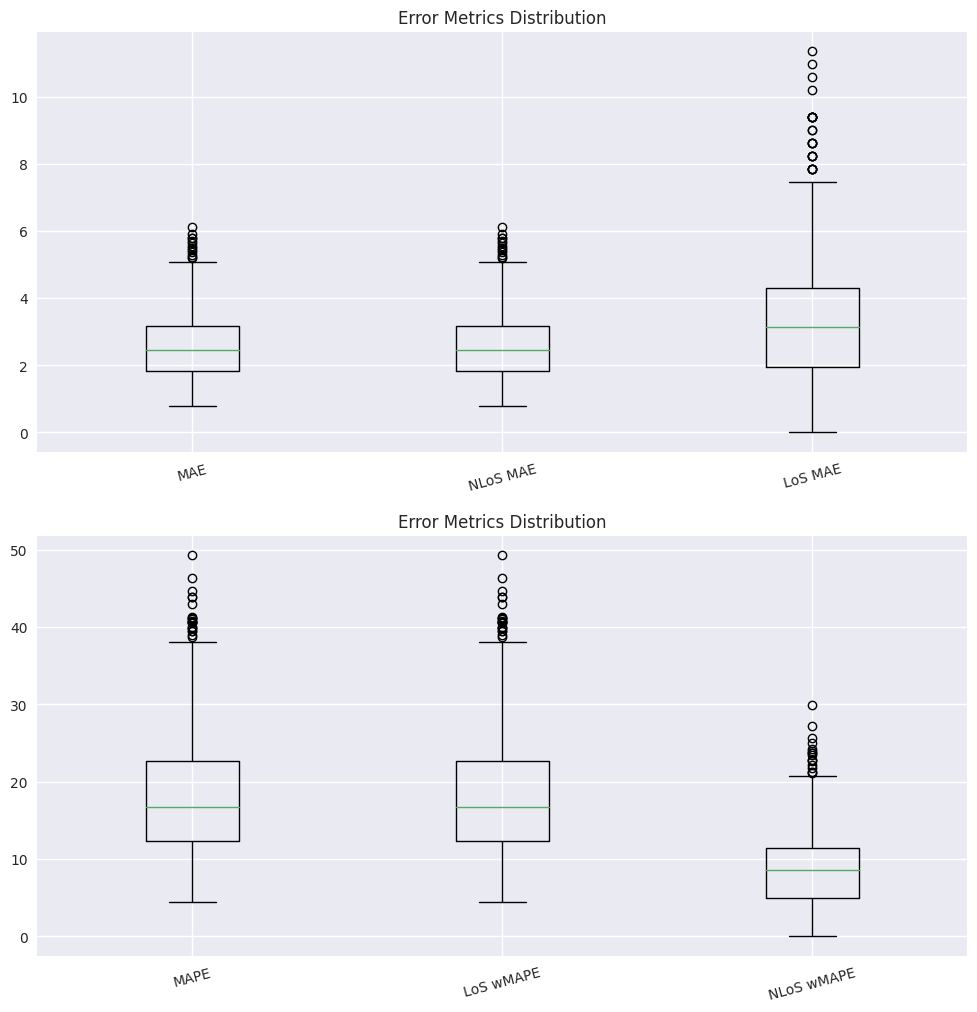

In [36]:
plt_style = 'seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else np.random.choice(plt.style.available)
plt.style.use(plt_style)
print(f"Using '{plt_style}' plotting style.")

values_0 = [
    merged_df[mae_model_1_name],
    merged_df[los_mae_model_1_name],
    merged_df[nlos_mae_model_1_name],
]

labels_0 = [
    "MAE",
    "NLoS MAE",
    "LoS MAE"
]

values_1 = [
    merged_df[mape_model_1_name],
    merged_df[los_wmape_model_1_name],
    merged_df[nlos_wmape_model_1_name]
]

labels_1 = [
    "MAPE",
    "LoS wMAPE",
    "NLoS wMAPE"
]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
ax[0].boxplot(values_0, notch=False)
ax[0].set_xticks(range(1, len(labels_0) + 1))
ax[0].set_xticklabels(labels_0, rotation=15)
ax[0].set_title("Error Metrics Distribution")

ax[1].boxplot(values_1, notch=False)
ax[1].set_xticks(range(1, len(labels_1) + 1))
ax[1].set_xticklabels(labels_1, rotation=15)
ax[1].set_title("Error Metrics Distribution")



print(f"\nMAE\n    - {model_1}: {merged_df[mae_model_1_name].mean():>0.2f}")
print(f"\nMAPE\n    - {model_1}: {merged_df[mape_model_1_name].mean():>0.2f}")
print(f"\nLoS MAE\n    - {model_1}: {merged_df[los_mae_model_1_name].mean():>0.2f}")
print(f"\nNLoS MAE\n    - {model_1}: {merged_df[nlos_mae_model_1_name].mean():>0.2f}")
print(f"\nLoS wMAPE\n    - {model_1}: {merged_df[los_wmape_model_1_name].mean():>0.2f}")
print(f"\nNLoS wMAPE\n    - {model_1}: {merged_df[nlos_wmape_model_1_name].mean():>0.2f}")

Example Image

/tmp/ipykernel_479799/3571709899.py:14: UserWarning: Overwriting the cmap 'unique_hsv' that was already in the registry.
  plt.colormaps.register(name="unique_hsv", cmap=unique_hsv, force=True)


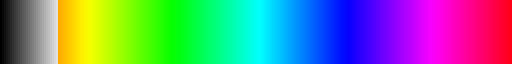

In [37]:
from matplotlib.colors import ListedColormap

def get_unique_hsv_cmap():
    unique_hsv_map = plt.get_cmap("hsv")(np.linspace(0, 1, 256))    # np.arange(0, 256)
    hsv_map = plt.get_cmap("hsv")
    for cur_idx in range(256):
        r, g, b, a = hsv_map(cur_idx)
        if r > 0.99 and g < (170/255):
            gray_value = cur_idx*8 / 255.0
            unique_hsv_map[cur_idx] = (gray_value, gray_value, gray_value, 1.0)
        else:
            break
    unique_hsv = ListedColormap(unique_hsv_map)
    plt.colormaps.register(name="unique_hsv", cmap=unique_hsv, force=True)
    return unique_hsv

get_unique_hsv_cmap()
plt.get_cmap("unique_hsv")

In [38]:
def get_same_pred_real_samples(pred_path:str, real_path:str, input_path:str, n_samples:int, ids=None):
    if not ids:
        # choose n random samples
        samples = random.sample(os.listdir(pred_path), n_samples)
        pred_samples = [os.path.join(pred_path, cur_image) for cur_image in samples]

        # get the used id's
        ids = []
        for cur_image in samples:
            cur_id = re.findall(r'\d+', string=cur_image)
            if len(cur_id) <= 0:
                raise ValueError(f"One image has no ID: {cur_image}")
            cur_id = cur_id[-1]
            ids += [cur_id]
    else:
        # get pred image
        pred_image_samples = []
        for target_id in ids:
            found = False
            for cur_image in os.listdir(real_path):
                cur_id = re.findall('\d+', string=cur_image)
                cur_id = cur_id[-1]
                if cur_id == target_id:
                    pred_image_samples += [cur_image]
                    found = True
                    break

            if not found:
                raise ValueError(f"Does not found pred image with id: {target_id}")
        pred_samples = [os.path.join(pred_path, cur_image) for cur_image in pred_image_samples]

    # get real image
    real_image_samples = []
    for target_id in ids:
        found = False
        for cur_image in os.listdir(real_path):
            cur_id = re.findall('\d+', string=cur_image)
            cur_id = cur_id[-1]
            if cur_id == target_id:
                real_image_samples += [cur_image]
                found = True
                break

        if not found:
            raise ValueError(f"Does not found real image with id: {target_id}")

    target_samples = [os.path.join(real_path, cur_image) for cur_image in real_image_samples]

    # get real image
    input_image_samples = []
    if input_path:
        for target_id in ids:
            found = False
            for cur_image in os.listdir(input_path):
                cur_id = re.findall('\d+', string=cur_image)
                cur_id = cur_id[-1]
                if cur_id == target_id:
                    input_image_samples += [cur_image]
                    found = True
                    break

            if not found:
                raise ValueError(f"Does not found input image with id: {target_id}")

    input_samples = [os.path.join(input_path, cur_image) for cur_image in input_image_samples]

    return input_samples, target_samples, pred_samples, ids

In [39]:
def plot(ax, path, title="", sub_image=None, cmap="plasma", plot=True, vmin=None, vmax=None):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    img = 255 - img

    if sub_image:
        img_2 = cv2.imread(sub_image, cv2.IMREAD_GRAYSCALE).astype(np.float32)
        img_2 = 255 - img_2

        assert img_2.shape == img.shape, "Shape mismatch"
        img = np.abs(img - img_2)
        # img = img - img_2
        # img[img < 0] = img[img < 0] * -1

    if plot:
        ax.axis("off")
        color_ax = ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(title)
        plt.colorbar(color_ax, ax=ax, fraction=0.046, pad=0.04)
    
    return img

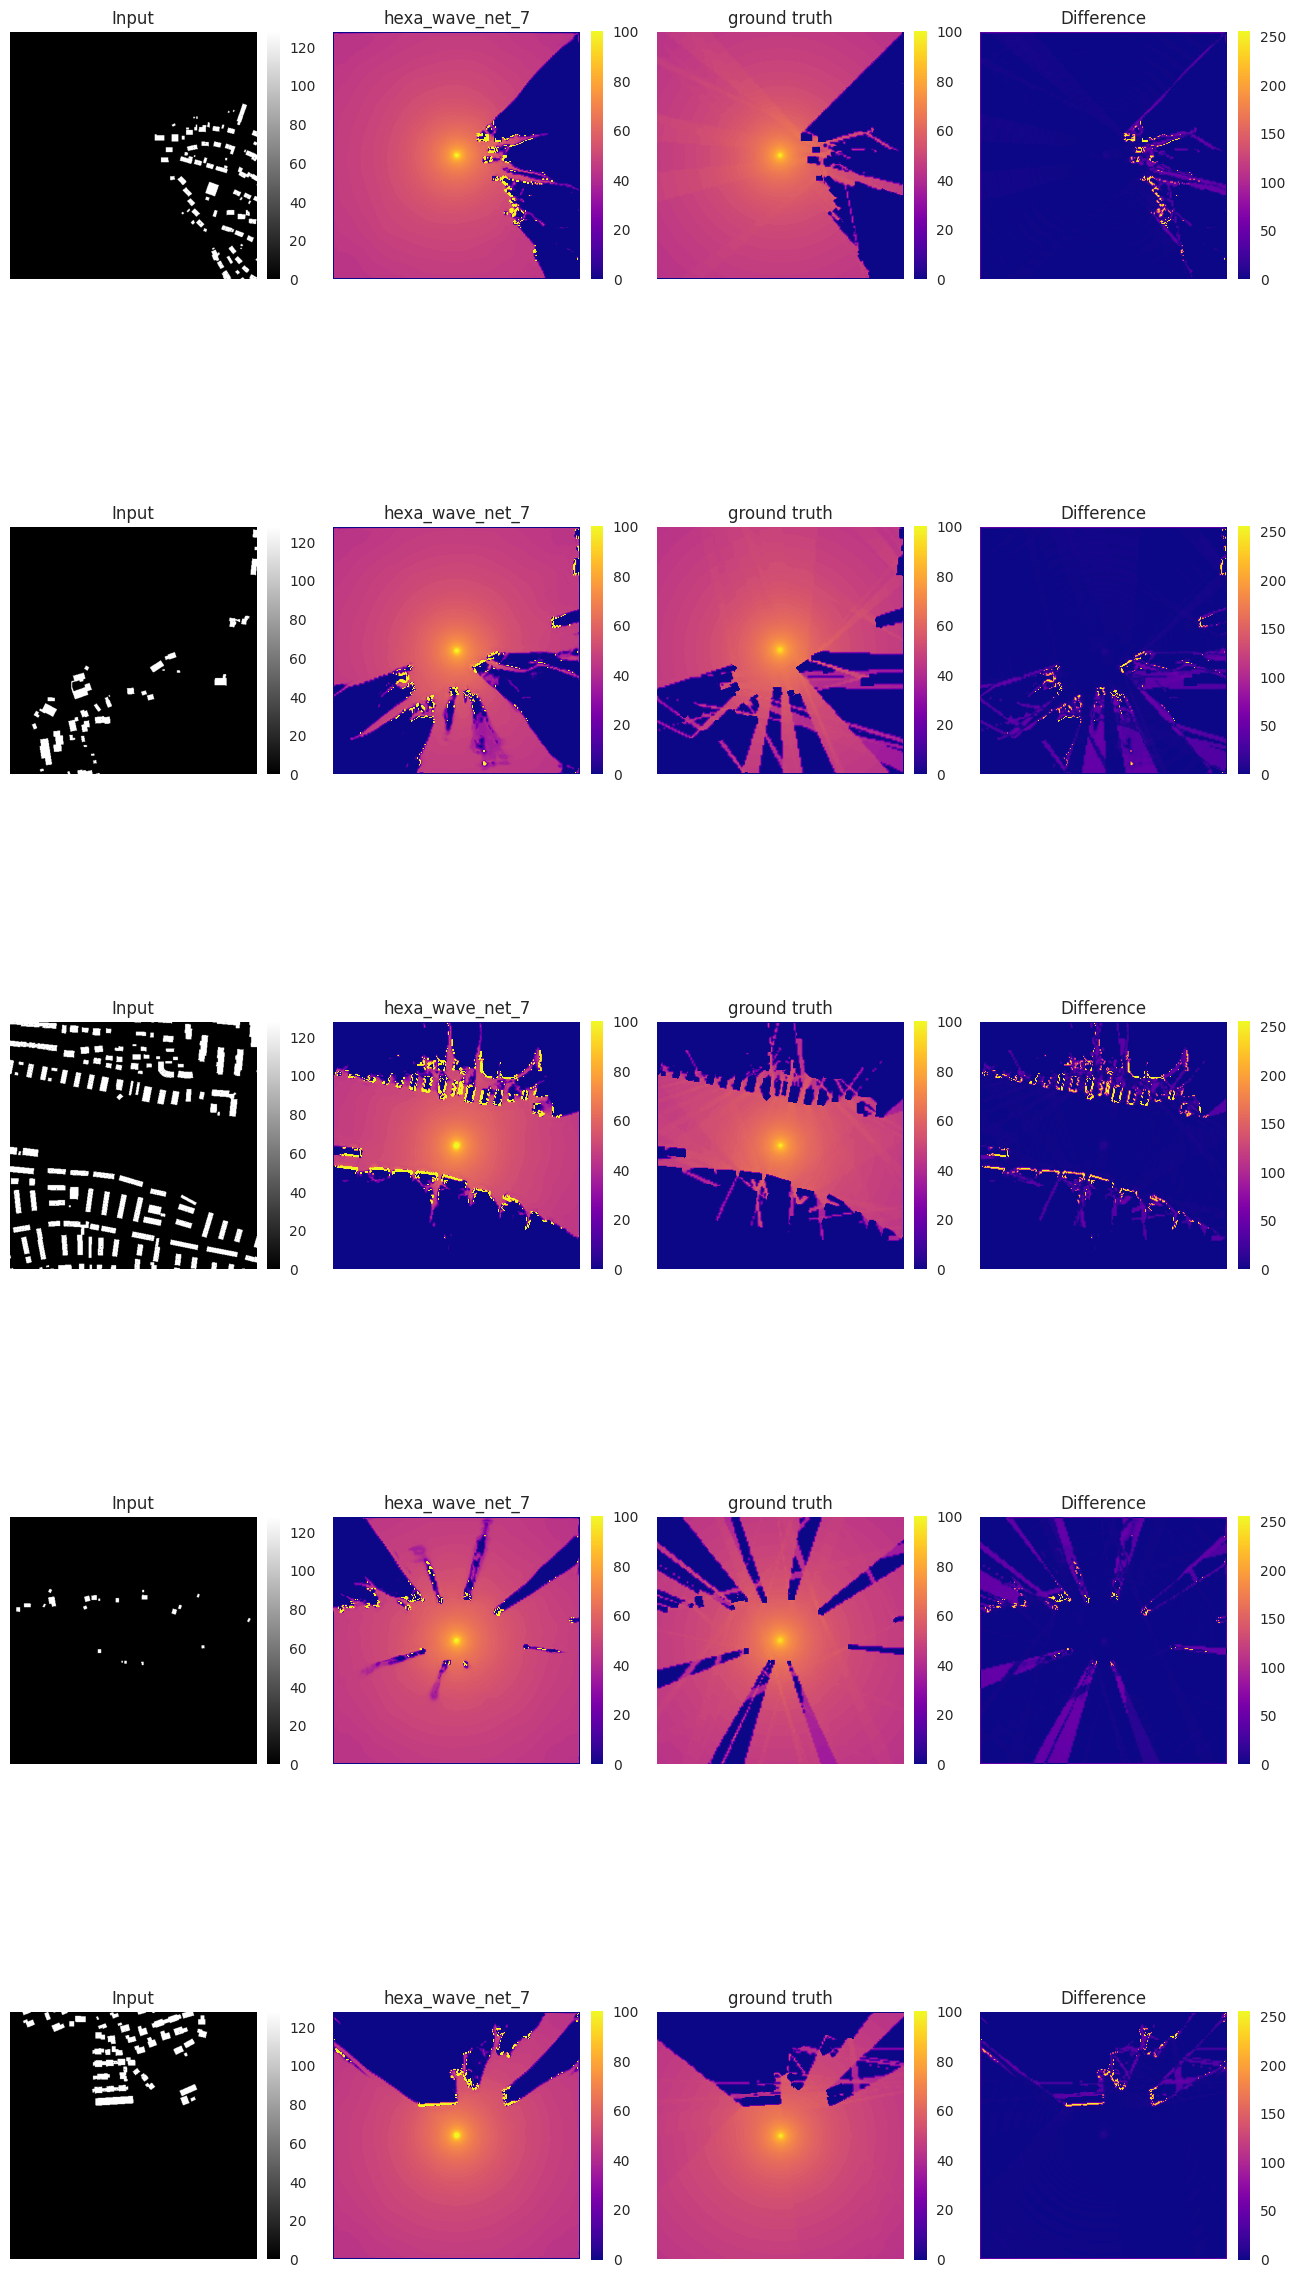

In [ ]:
n_samples = 5

input_samples, real, pred_model, ids = get_same_pred_real_samples(f"../../data/eval/{model_1}/pred",
                                                                  f"../../data/eval/{model_1}/real",
                                                                  f"../../data/eval/{model_1}/osm",
                                                                  n_samples)


fig, ax = plt.subplots(nrows=n_samples, ncols=4, figsize=(4*4, n_samples*6))
# ax = ax.ravel()

ax_idx = 0

for idx, cur_path in enumerate(input_samples):
    plot(ax[idx][0], path=cur_path, title=f"Input", cmap="gray")

for idx, cur_path in enumerate(pred_model):
    plot(ax[idx][1], path=cur_path, title=f"{model_1}")  #, vmax=100)

for idx, cur_path in enumerate(real):
    plot(ax[idx][2], path=cur_path, title=f"ground truth")  # , vmax=100)

for idx, cur_path in enumerate(pred_model):
    plot(ax[idx][3], path=cur_path, title=f"Difference", sub_image=real[idx])

plt.subplots_adjust(hspace=0.5)

plt.show();

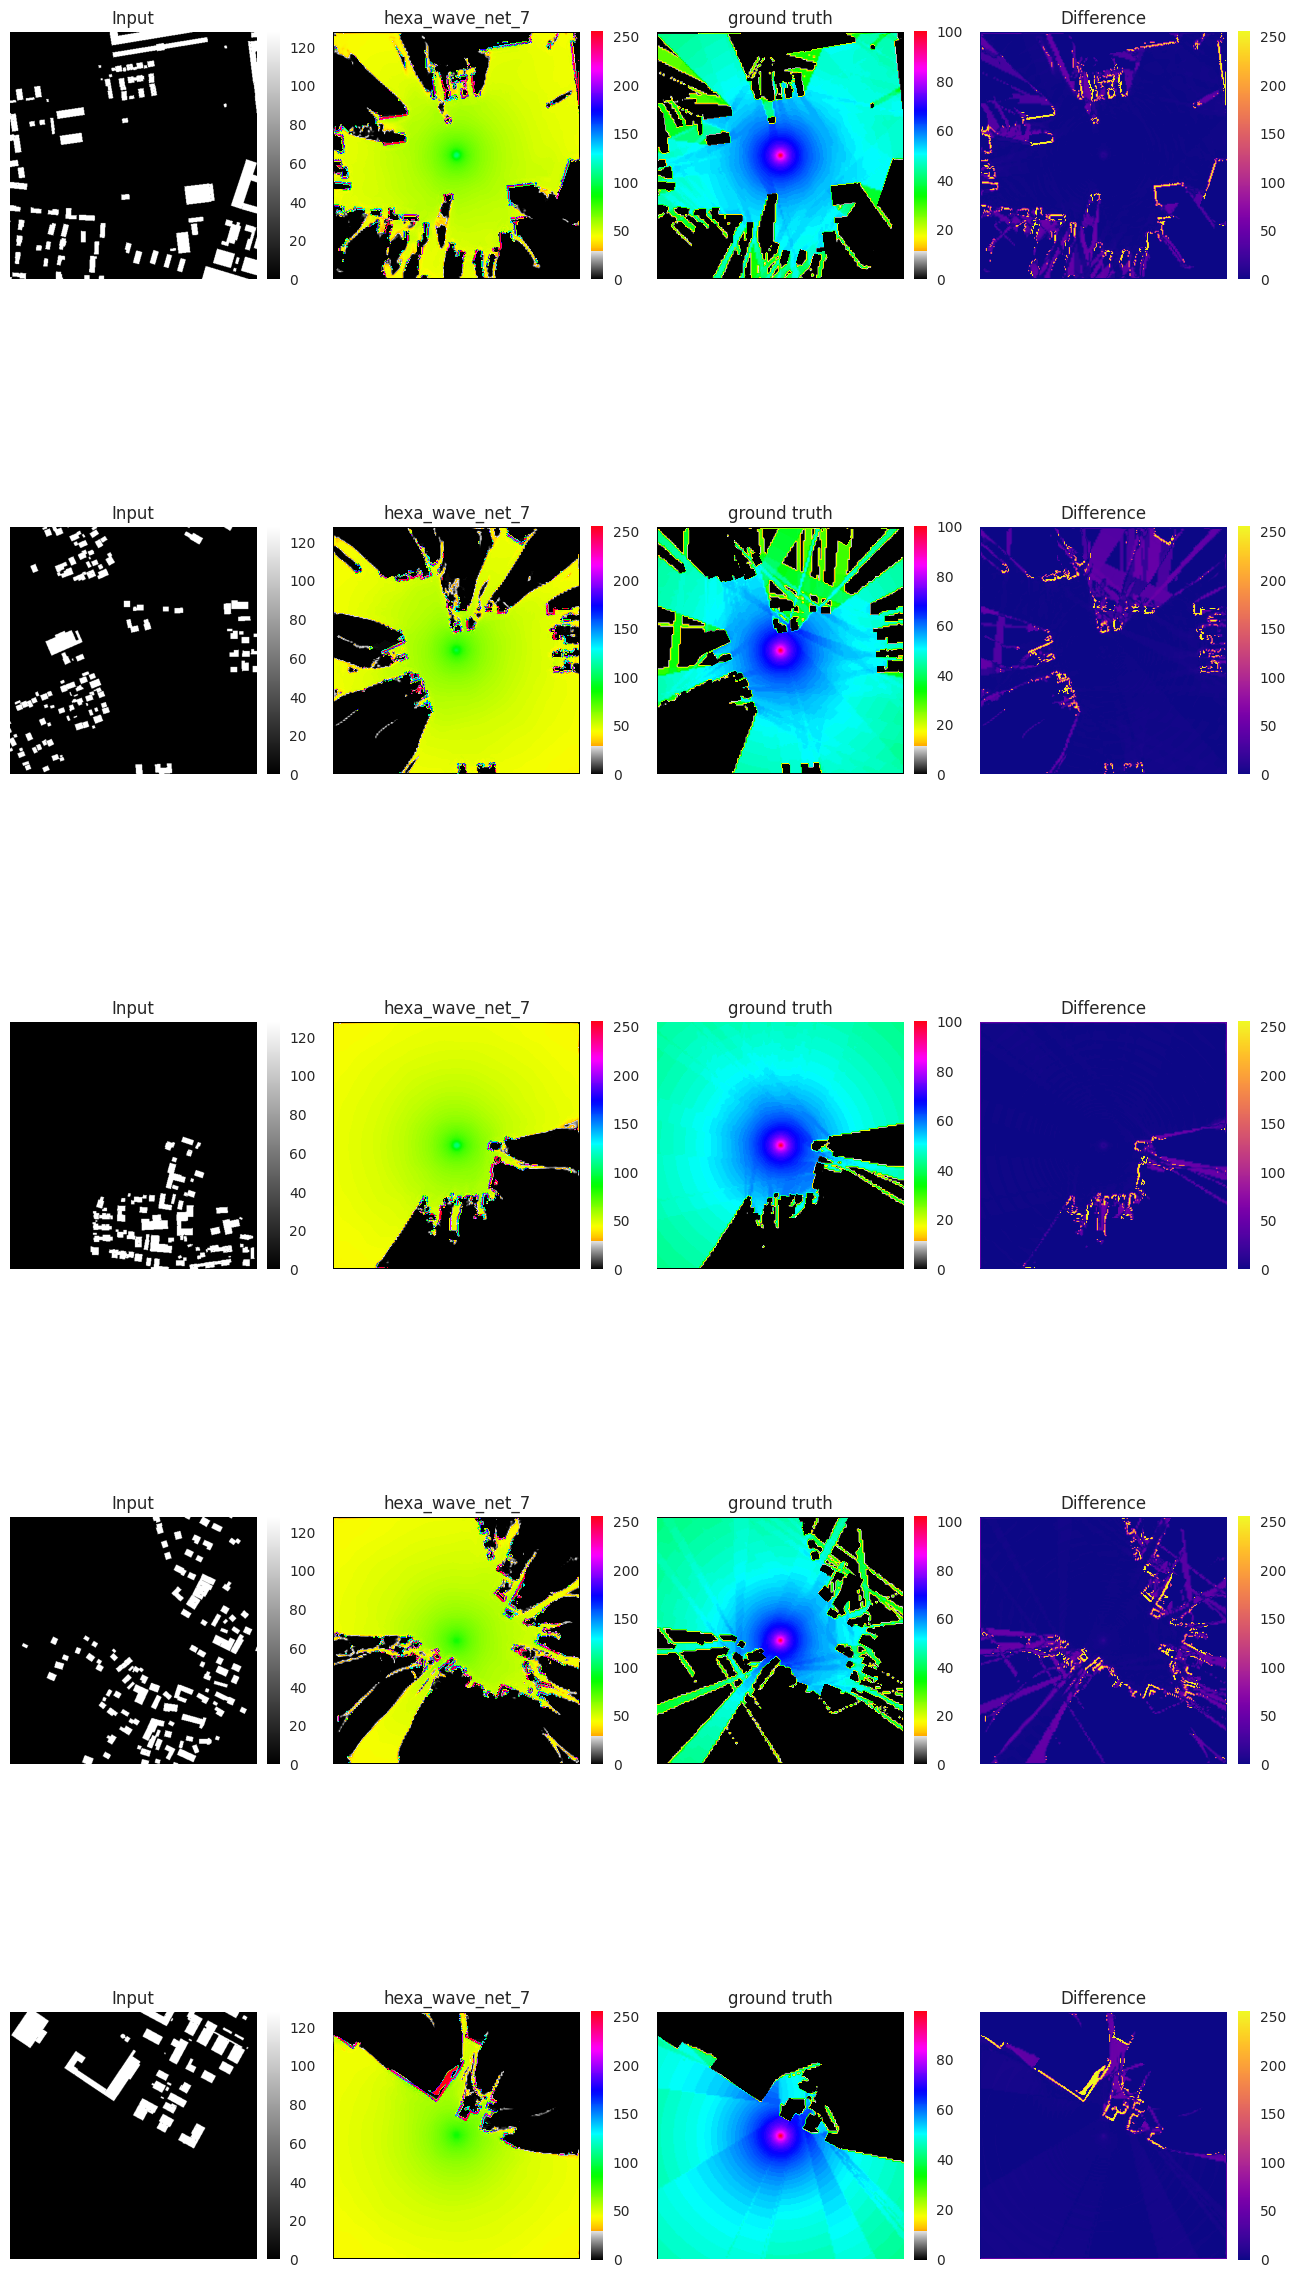

In [41]:
n_samples = 5

input_samples, real, pred_model, ids = get_same_pred_real_samples(f"../../data/eval/{model_1}/pred",
                                                                  f"../../data/eval/{model_1}/real",
                                                                  f"../../data/eval/{model_1}/osm",
                                                                  n_samples)


fig, ax = plt.subplots(nrows=n_samples, ncols=4, figsize=(4*4, n_samples*6))
# ax = ax.ravel()

ax_idx = 0

for idx, cur_path in enumerate(input_samples):
    plot(ax[idx][0], path=cur_path, title=f"Input", cmap="gray")

for idx, cur_path in enumerate(pred_model):
    plot(ax[idx][1], path=cur_path, title=f"{model_1}", cmap="unique_hsv")

for idx, cur_path in enumerate(real):
    plot(ax[idx][2], path=cur_path, title=f"ground truth", cmap="unique_hsv")

for idx, cur_path in enumerate(pred_model):
    plot(ax[idx][3], path=cur_path, title=f"Difference", sub_image=real[idx])

plt.subplots_adjust(hspace=0.5)

plt.show();

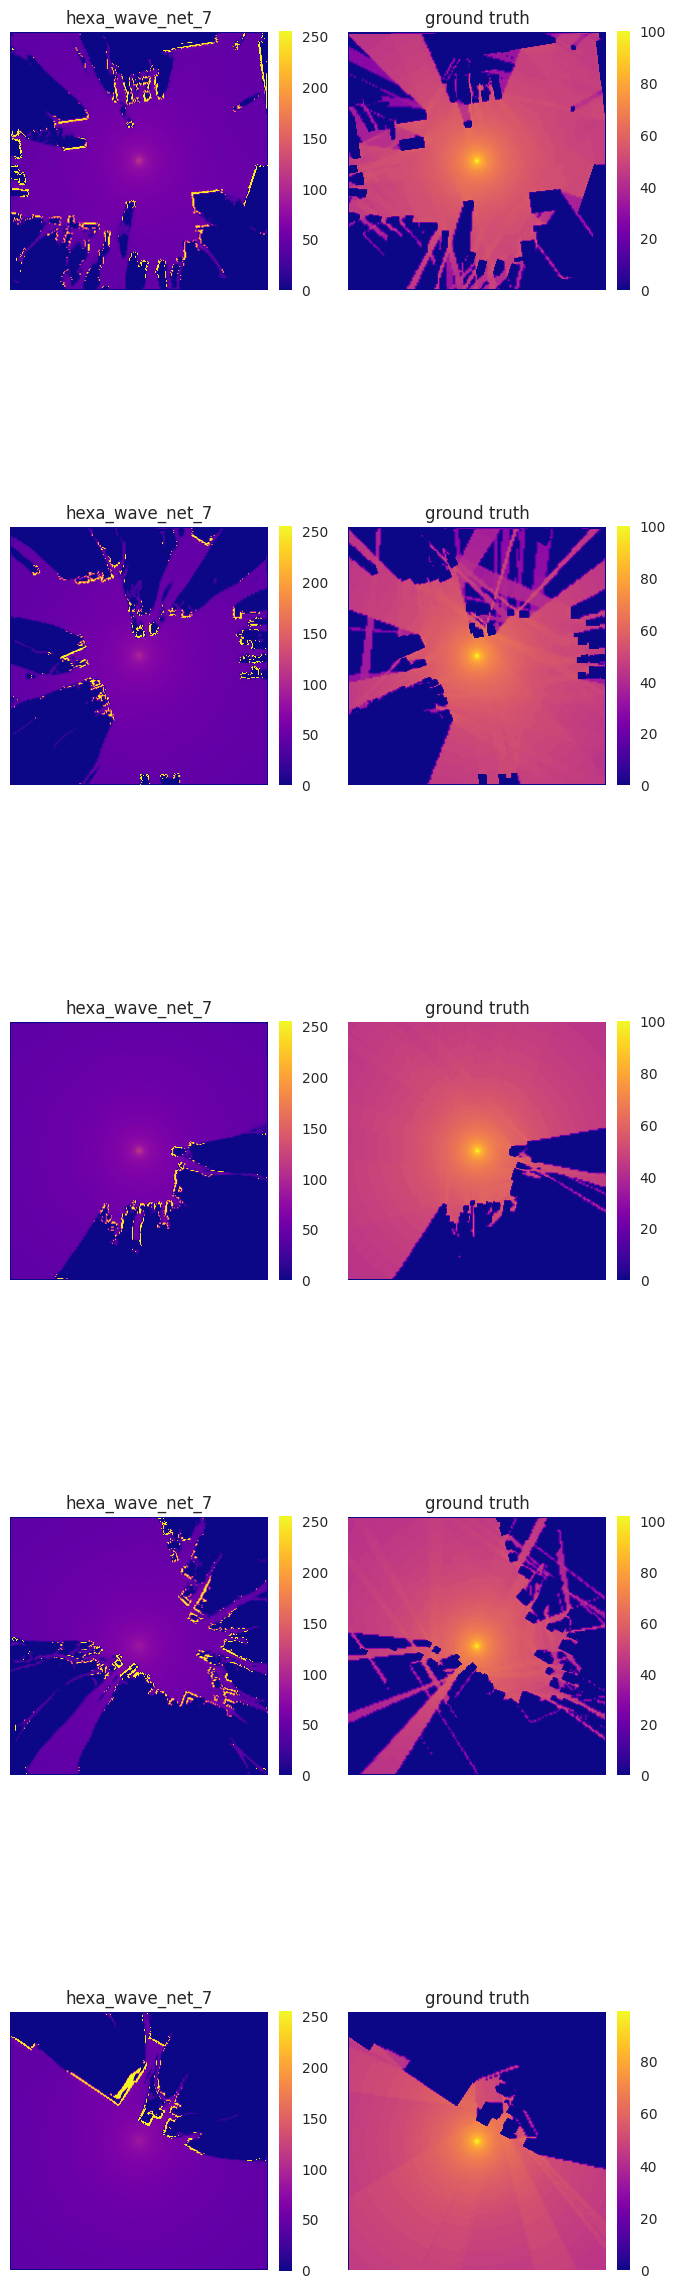

In [42]:
fig, ax = plt.subplots(nrows=n_samples, ncols=2, figsize=(2*4, n_samples*6))
# ax = ax.ravel()

ax_idx = 0

for idx, cur_path in enumerate(pred_model):
    plot(ax[idx][0], path=cur_path, title=f"{model_1}")

for idx, cur_path in enumerate(real):
    plot(ax[idx][1], path=cur_path, title=f"ground truth")

plt.subplots_adjust(hspace=0.5)

plt.show();

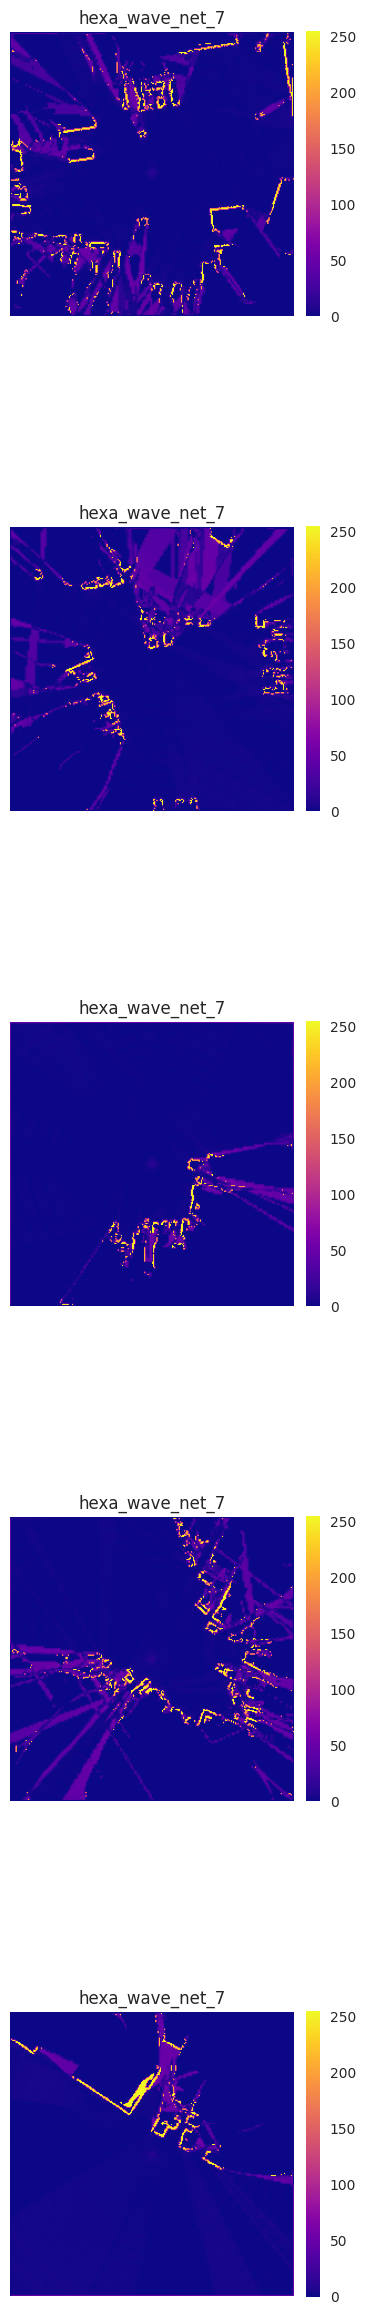

In [43]:
fig, ax = plt.subplots(nrows=n_samples, ncols=1, figsize=(1*4, n_samples*6))

for idx, cur_path in enumerate(pred_model):
    plot(ax[idx], path=cur_path, title=f"{model_1}", sub_image=real[idx], cmap="plasma")

plt.subplots_adjust(hspace=0.5)
plt.show();

Inspect some single images in more detail here:

In [44]:
from skimage.measure import block_reduce

def plot_image_with_values(img, block_size=8):
    # Compute mean over non-overlapping blocks
    mean_img = block_reduce(img, block_size=(block_size, block_size), func=np.mean)
    max_value = mean_img.max()

    # Plot the mean image
    plt.imshow(mean_img, cmap='gray', interpolation='nearest')
    plt.colorbar(label='Mean Value')

    # Annotate each block with the mean
    for i in range(mean_img.shape[0]):
        for j in range(mean_img.shape[1]):
            val = mean_img[i, j]
            color = 'white' if val < max_value/1.5 else 'black'
            # color = int(255 - val)
            plt.text(j, i, f'{val:.1f}', ha='center', va='center',
                     color=color, fontsize=6)

    plt.title(f'Mean Values over {block_size}x{block_size} Blocks')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

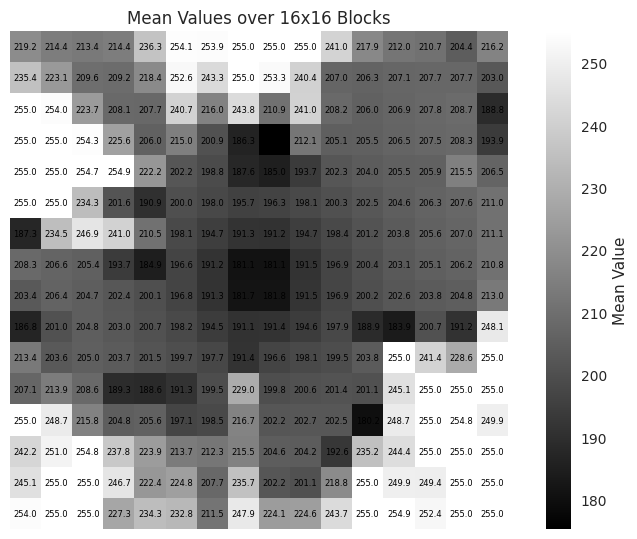

In [45]:
img_path = pred_model[0]
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(float)

plot_image_with_values(img, block_size=16)

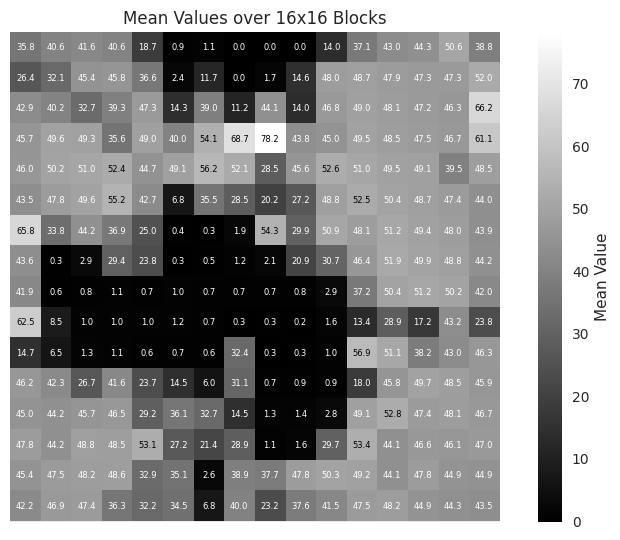

In [46]:
img = plot(None, path=pred_model[0], title=f"{model_1}", sub_image=real[idx], plot=False)
plot_image_with_values(img, block_size=16)